In [1]:
# Preparing Data for Deep Learning Model and Comparison models
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import time
import osmnx as ox
from shapely.geometry import Point
import contextily as cx # for basemap

In [28]:



# making list of file paths
csv_folder_path = 'C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/Data/UBDC_Zoopla_Data/DataSet/BR'
csv_file_paths = [os.path.join(csv_folder_path, f) for f in os.listdir(csv_folder_path) if f.endswith('.csv')]

# making empty list to store dataframes
processed_dfs = []

# only reading in useful columns
cols_to_read = [#'listing_id', 
                #'property_id', 
                'result_count',
                'category',
                'num_bathrooms',
                'num_bedrooms',
                'num_recepts',
                'num_floors', 
                'listing_status', 
                #'post_town', 
                'status',
                'first_marketed_date',
                'last_marketed_date',
                'displayable_address',
                'incode',
                'outcode', # these two make the postcode. outcode then incode. 
                'property_type', 
                #'property_number', # lots of missing values
                'price', # y
               ]

# processing interest rates
InterestRates = pd.read_csv("C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Information Retrieval/Assessment1/InterestRate.csv")

# setting "Date Changed" as date format
InterestRates['Date Changed'] = pd.to_datetime(InterestRates['Date Changed'])
# renaming column to match df dates
InterestRates = InterestRates.rename(columns={'Date Changed': 'last_marketed_date'})
# sort by date
InterestRates = InterestRates.sort_values(by='last_marketed_date', ascending=False)

# making array of bands (from - TaxBand.csv)
bands = np.array([0, 40000, 52000, 68000, 88000, 120000, 160000, 320000, np.inf])
# adjusting bands for inflation (1991 to 2019) 
inflated_bands = bands * 2.1483 
# making band labels
band_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# Reading in costs per band per LAD data
LADTaxRatesperBand = pd.read_csv("C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Information Retrieval/Assessment1/LADTaxRatesperBand.csv")
# doesn't contain LAD codes - amgiuity concern
# eg difference "Hammersmith & Fulham" vs "Hammersmith and Fulham"

# melting dataframe so that it is 'tidy' (unfortunatly creates repetition)
melted_LADTaxRatesperBand = pd.melt(LADTaxRatesperBand, id_vars=['LAD'], 
                                    var_name='TaxBand', 
                                    value_name='CouncilTaxEst')
# repetition acceptatble since data is small and finite: not dependant on number of properties.

# assigning council tax costs to each property
# merging melted_LADTaxRatesperBand LAD with LAD_polygon_df LAD11NM 
# doing this by first words to mitigate ambiguity
melted_LADTaxRatesperBand['key'] = melted_LADTaxRatesperBand['LAD'].str.split().str[0]

# reading in GB_PostalCodes.csv (created in  PostCodes.ipynb) 
GB_PostalCodes = pd.read_csv('C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/Data/GB_PostalCodes.csv', 
                      index_col=False)

# reading in LAD boundaries (made in GroupingLADs.ipynb)
LAD_polygon_df = gpd.read_file('C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/LAD_polygon_df.shp')

# reading in the POI shapefile
pois = gpd.read_file('C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/Data/greater_london_poi/gis_osm_pois_a_free_1.SHP')
                                     

In [29]:
# looping through each CSV
for file_path in csv_file_paths:

    data = pd.read_csv(file_path, usecols=cols_to_read)

    # filtering to keep only properties for sale (not rentals)
    df = data[data['listing_status'] == 'sale']
    
    # only keeping residential properties
    df = df[df['category'] == 'Residential']
    
    # removing any price NAs (dependant variable)
    df = df.dropna(subset=['price'])
    
    # removing any date NAs
    df = df.dropna(subset=['first_marketed_date', 'last_marketed_date'])

    # setting columns with dates correectly
    df['first_marketed_date'] = pd.to_datetime(df['first_marketed_date'])
    df['last_marketed_date'] = pd.to_datetime(df['last_marketed_date'])
    
    # converting dates to days since set day - 16/11/2022 (metadata creation date)
    # making col for how many days since it was last marketed
    df['last_marketed_days'] = (pd.to_datetime('2022-11-16')-pd.to_datetime(df['last_marketed_date'])).dt.days#.astype(int)
   
    # making col for how many days properties marketed for
    df['marketed_duration'] = (pd.to_datetime(df['last_marketed_date'])-pd.to_datetime(df['first_marketed_date'])).dt.days#.astype(int)
    
    
    # one-hot encoding property_type
    # first converting low frequency property types and NAs to "other"
    frequent_types = ['Flat', 'Terraced house', 'Semi-detached house', 'Detached house', 
                 'End terrace house', 'Maisonette', 'Town house', 'Bungalow', 
                 'Detached bungalow', 'Link-detached house', 'Studio', 'Cottage', 
                 'Semi-detached bungalow']
    
    def categorize_property_type(x):
        if pd.isna(x):
            return 'other'
        elif x in frequent_types:
            return x
        else:
            return 'other'

    df['property_type'] = df['property_type'].apply(categorize_property_type)
    
    # now one-hot encoding
    df = pd.get_dummies(df, columns=['property_type'])
    
    # one-hot encoding status too (sold or for sale)  
    df['status'] = df['status'].fillna('unknown')
    df = pd.get_dummies(df, columns=['status'])
    
    # ranking df by last_marketed_date (allows efficient addition of interest rates)
    df = df.sort_values(by='last_marketed_date', ascending=False)
    
    # attaching interest rates
    df['closest_prior_idx'] = len(InterestRates) - np.searchsorted(InterestRates['last_marketed_date'].values[::-1], 
                                                                          df['last_marketed_date'].values, side='right')
    # Extracting rates using the indices
    df['IntRate'] = InterestRates.loc[df['closest_prior_idx'], 'Rate'].values
    
    
        # now assigning tax bands (A-H) on inflated_bands for psuedo_zoopla
    df['TaxBand'] = pd.cut(df['price'], bins=inflated_bands, labels=band_labels, right=False)

    
        # making postcode col as key to match with GB_PostalCodes
    df['postcode'] = df['outcode'] + ' ' + df['incode']

    df.drop(columns=['incode', 'outcode'], inplace=True)

    # attaching coordinates to df 
    df = pd.merge(df, GB_PostalCodes, on='postcode', how='left')  
    
    
    # converting to geodataframe
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # setting CRS (WGS84)
    df.set_crs(epsg=4326, inplace=True)
    
    # if CRS do not match
    if df.crs != LAD_polygon_df.crs:
        LAD_polygon_df = LAD_polygon_df.to_crs(df.crs)
    
    # assigning LADs to each row based on points within LAD boundaries
    df = gpd.sjoin(df, LAD_polygon_df, how="left", predicate="within")
    
    # Checking spatial join
    print("Number of rows after spatial join:", len(df))
    print("Number of nulls in LAD11NM after spatial join:", df['LAD11NM'].isnull().sum())
    
    
    # assignign property tax bands from inflated bands, price, and LAD
    # using first word to reduce ambiguity (eg "Hammersmith & Fulham" vs "Hammersmith and Fulham")
    df['key'] = df['LAD11NM'].str.split().str[0]
    df = pd.merge(df, melted_LADTaxRatesperBand, how='left', on=['key', 'TaxBand'])

    processed_dfs.append(df)


Number of rows after spatial join: 7148
Number of nulls in LAD11NM after spatial join: 0
Number of rows after spatial join: 5777
Number of nulls in LAD11NM after spatial join: 10
Number of rows after spatial join: 6512
Number of nulls in LAD11NM after spatial join: 1
Number of rows after spatial join: 1821
Number of nulls in LAD11NM after spatial join: 0
Number of rows after spatial join: 6222
Number of nulls in LAD11NM after spatial join: 7
Number of rows after spatial join: 6782
Number of nulls in LAD11NM after spatial join: 86
Number of rows after spatial join: 2844
Number of nulls in LAD11NM after spatial join: 0
Number of rows after spatial join: 2847
Number of nulls in LAD11NM after spatial join: 2832
Number of rows after spatial join: 1836
Number of nulls in LAD11NM after spatial join: 1834
Number of rows after spatial join: 3508
Number of nulls in LAD11NM after spatial join: 3508
Number of rows after spatial join: 3229
Number of nulls in LAD11NM after spatial join: 3229
Number 

In [30]:

# combining dataframes
combined_df = pd.concat(processed_dfs, ignore_index=True)

In [31]:


print(combined_df['last_marketed_date'].max())

print(combined_df['first_marketed_date'].min())

2021-12-24 13:00:52
2001-05-24 00:00:00


In [32]:
print(combined_df['last_marketed_date'].quantile(0.75))
print(combined_df['first_marketed_date'].quantile(0.75))

2019-11-01 23:48:53
2019-05-21 10:35:56.500000


In [5]:
combined_df.tail()


,result_count,category,num_bathrooms,num_bedrooms,num_recepts,num_floors,listing_status,first_marketed_date,last_marketed_date,displayable_address,...,postcode,latitude,longitude,geometry,index_right,LAD11CD,LAD11NM,key,LAD,CouncilTaxEst
321287,3,Residential,2,3,3,0,sale,2002-07-08,2002-07-08,"Hillcroft Crescent, Wembley HA9",...,HA9 8EE,51.5591,-0.2876,POINT (-0.28760 51.55910),4.0,E09000005,Brent,Brent,Brent,2286.34
321288,4,Residential,1,3,1,0,sale,2002-06-11,2002-06-11,"East Hill, Wembley HA9",...,HA9 9PT,51.5694,-0.2817,POINT (-0.28170 51.56940),4.0,E09000005,Brent,Brent,Brent,2638.08
321289,2,Residential,1,2,1,0,sale,2002-05-29,2002-05-29,"Park Lane, Wembley HA9",...,HA9 7SF,51.5557,-0.2925,POINT (-0.29250 51.55570),4.0,E09000005,Brent,Brent,Brent,1582.85
321290,8,Residential,2,3,3,0,sale,2002-05-28,2002-05-28,"Pempath Place, Wembley HA9",...,HA9 8QW,51.5674,-0.3052,POINT (-0.30520 51.56740),4.0,E09000005,Brent,Brent,Brent,2286.34
321291,3,Residential,1,3,1,0,sale,2002-05-20,2002-05-20,"Mayfields Close, Wembley HA9",...,HA9 9PP,51.5683,-0.2838,POINT (-0.28380 51.56830),4.0,E09000005,Brent,Brent,Brent,2638.08


In [6]:
combined_df.shape

(321292, 43)

In [7]:
combined_df["LAD"].value_counts(dropna=False)
# only has 21 / 32
#  44271 NaNs

NaN               44433
Croydon           39274
Bromley           35014
Waltham Forest    27642
Bexley            27642
Harrow            25337
Tower Hamlets     23682
Newham            21908
Enfield           18138
Barnet            12195
Hillingdon        11591
Hackney           10159
Brent              9499
Merton             5601
Redbridge          4084
Lewisham           1944
Islington          1390
Sutton             1333
Camden              159
Greenwich           138
Ealing              127
Havering              2
Name: LAD, dtype: int64

In [8]:
combined_df["LAD11NM"].value_counts(dropna=False)


NaN               43205
Croydon           39274
Bromley           35014
Bexley            27642
Waltham Forest    27642
Harrow            25337
Tower Hamlets     23682
Newham            21908
Enfield           18138
Barnet            12195
Hillingdon        11591
Hackney           10159
Brent              9499
Merton             5601
Redbridge          4084
Lewisham           1944
Islington          1390
Sutton             1333
City of London     1228
Camden              159
Greenwich           138
Ealing              127
Havering              2
Name: LAD11NM, dtype: int64

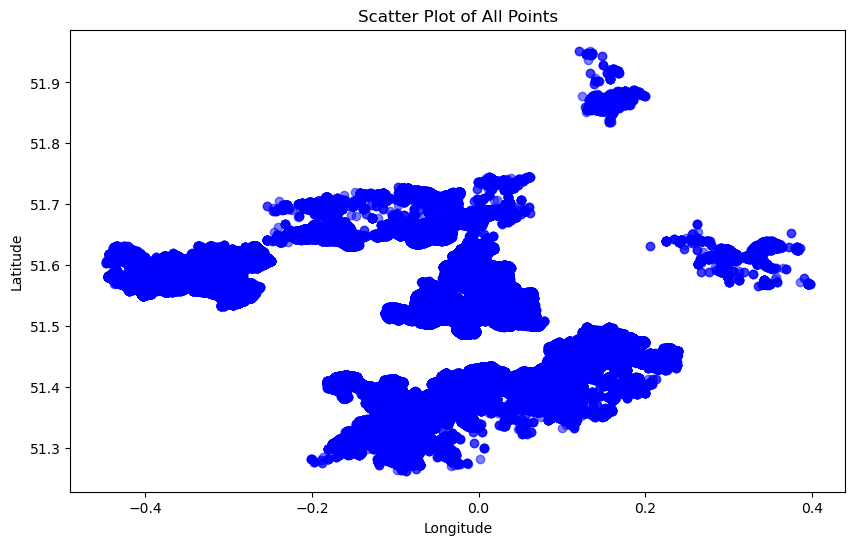

In [9]:
# plotting to see geolocations of points
import matplotlib.pyplot as plt

# creating scatter plot directly from dataframe
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='blue', marker='o', alpha=0.5)

# adding titles and labels
plt.title('Scatter Plot of All Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [10]:
# can drop rows that are NA for combined_df["LAD11NM"] because that means they arent in london
combined_df = combined_df.dropna(subset=['LAD11NM'])
combined_df.shape

(278087, 43)

In [11]:
print(combined_df['LAD11NM'].value_counts())

Croydon           39274
Bromley           35014
Waltham Forest    27642
Bexley            27642
Harrow            25337
Tower Hamlets     23682
Newham            21908
Enfield           18138
Barnet            12195
Hillingdon        11591
Hackney           10159
Brent              9499
Merton             5601
Redbridge          4084
Lewisham           1944
Islington          1390
Sutton             1333
City of London     1228
Camden              159
Greenwich           138
Ealing              127
Havering              2
Name: LAD11NM, dtype: int64


In [12]:
# droppping Havering because only two and they arent close to others
combined_df = combined_df[combined_df['LAD11NM'] != 'Havering']
combined_df['LAD11NM'] = combined_df['LAD11NM'].astype('category')
combined_df.shape

(278085, 43)

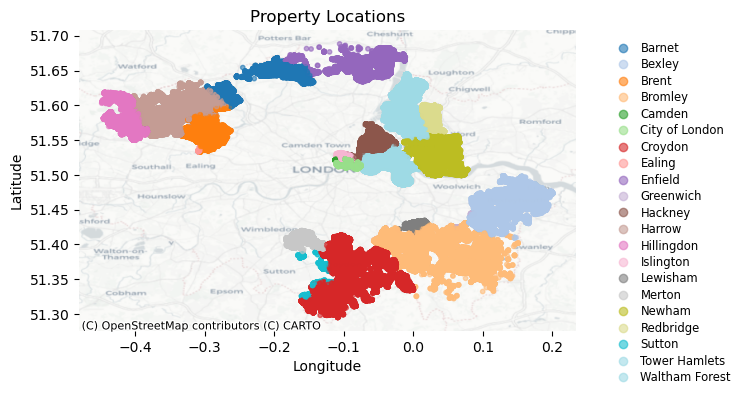

In [13]:
# replotting for only London (area of study)

fig, ax = plt.subplots()

scatter = ax.scatter(combined_df['longitude'], 
                     combined_df['latitude'], 
                     c=combined_df['LAD11NM'].astype('category').cat.codes, 
                     marker='o', 
                     s=10, # making dots smaller
                     alpha=0.6, 
                     cmap='tab20')

# Adding titles and labels
plt.title('Property Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# adding basemap
cx.add_basemap(ax, crs=combined_df.crs.to_string(), source=cx.providers.CartoDB.Positron)

# removing spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adding legend
handles, labels = scatter.legend_elements(prop="colors", num=len(combined_df['LAD11NM'].cat.categories))
legend = ax.legend(handles, combined_df['LAD11NM'].cat.categories,
                   title="", 
                   bbox_to_anchor=(1.05, 1),
                   fontsize='small',
                   handletextpad=0.5,
                   labelspacing=0.3,
                   borderpad=0.5, 
                   frameon=False)

# Saving to png
plt.savefig('Property_map.png', dpi=400, bbox_inches='tight')
plt.show()

In [14]:
# checking to see missing latitude and longitude
combined_df[['latitude', 'longitude']].isna().sum()
# none


latitude     0
longitude    0
dtype: int64

In [15]:
combined_df.columns

Index(['result_count', 'category', 'num_bathrooms', 'num_bedrooms',
       'num_recepts', 'num_floors', 'listing_status', 'first_marketed_date',
       'last_marketed_date', 'displayable_address', 'price',
       'last_marketed_days', 'marketed_duration', 'property_type_Bungalow',
       'property_type_Cottage', 'property_type_Detached bungalow',
       'property_type_Detached house', 'property_type_End terrace house',
       'property_type_Flat', 'property_type_Link-detached house',
       'property_type_Maisonette', 'property_type_Semi-detached bungalow',
       'property_type_Semi-detached house', 'property_type_Studio',
       'property_type_Terraced house', 'property_type_Town house',
       'property_type_other', 'status_for_sale', 'status_sale_under_offer',
       'status_sold', 'closest_prior_idx', 'IntRate', 'TaxBand', 'postcode',
       'latitude', 'longitude', 'geometry', 'index_right', 'LAD11CD',
       'LAD11NM', 'key', 'LAD', 'CouncilTaxEst'],
      dtype='object')

In [16]:
# dropping surplus columns before exporting
columns_to_drop = ['category', 'listing_status', 'index_right', 'LAD11CD', 'key', 'LAD', 
                   'displayable_address', 'first_marketed_date', 
                   'last_marketed_date', 'closest_prior_idx', 
                   'TaxBand', 'postcode']
combined_df = combined_df.drop(columns_to_drop, axis=1)

In [17]:
combined_df = combined_df.dropna()

In [18]:
combined_df.shape

(197636, 31)

In [19]:
pd.set_option('display.max_columns', None)
combined_df.head()

,result_count,num_bathrooms,num_bedrooms,num_recepts,num_floors,price,last_marketed_days,marketed_duration,property_type_Bungalow,property_type_Cottage,property_type_Detached bungalow,property_type_Detached house,property_type_End terrace house,property_type_Flat,property_type_Link-detached house,property_type_Maisonette,property_type_Semi-detached bungalow,property_type_Semi-detached house,property_type_Studio,property_type_Terraced house,property_type_Town house,property_type_other,status_for_sale,status_sale_under_offer,status_sold,IntRate,latitude,longitude,geometry,LAD11NM,CouncilTaxEst
0,2,1,2,1,0,260000,328,225,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,51.4301,0.0145,POINT (0.01450 51.43010),Lewisham,2288.65
1,1,1,3,2,0,350000,328,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.25,51.4250,0.0142,POINT (0.01420 51.42500),Bromley,2561.28
2,2,1,3,1,0,510000,342,297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.10,51.4248,0.0240,POINT (0.02400 51.42480),Bromley,2561.28
3,2,2,3,2,0,475000,343,274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.10,51.4271,-0.0048,POINT (-0.00480 51.42710),Lewisham,2640.75
4,3,2,2,1,0,375000,343,506,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.10,51.4091,0.0182,POINT (0.01820 51.40910),Bromley,2561.28


In [20]:
combined_df.geometry.type.unique()

array(['Point'], dtype=object)

In [21]:
# Adding POIs

# converting multipolygons to point geometries by using centroids
pois['geometry'] = pois.centroid

# ensuring POIs and combined_df have the same CRS and transform to EPSG:3857 for meter-based calculations
combined_df_buffers = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.longitude, combined_df.latitude), crs='EPSG:4326')

combined_df_buffers = combined_df_buffers.to_crs(epsg=3857)
pois = pois.to_crs(epsg=3857)

# setting buffering radius  (500 meters)
radius = 500  

# putting buffers around combined_df points
combined_df_buffers['geometry'] = combined_df_buffers.geometry.buffer(radius)

# performing spatial join to find POIs in each buffer
joined = gpd.sjoin(pois, combined_df_buffers, predicate='intersects')

# calculating the POI density score by counting POIs within each buffer (IE POIs per 500m radius)
poi_density_scores = joined.groupby('index_right').size()

# adding  POI density score to combined_df
combined_df['POIdensity_score'] = combined_df.index.map(poi_density_scores).fillna(0)

# adding latitude and longitude back as variables
combined_df['latitude'] = combined_df.geometry.y
combined_df['longitude'] = combined_df.geometry.x

C:\Users\lewil\AppData\Local\Temp\ipykernel_23780\802328211.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois['geometry'] = pois.centroid


In [22]:
# inspecting the POI density scores have been added correctly
print(combined_df.head())

   result_count  num_bathrooms  num_bedrooms  num_recepts  num_floors   price  \
0             2              1             2            1           0  260000   
1             1              1             3            2           0  350000   
2             2              1             3            1           0  510000   
3             2              2             3            2           0  475000   
4             3              2             2            1           0  375000   

   last_marketed_days  marketed_duration  property_type_Bungalow  \
0                 328                225                     0.0   
1                 328                  1                     0.0   
2                 342                297                     0.0   
3                 343                274                     0.0   
4                 343                506                     0.0   

   property_type_Cottage  property_type_Detached bungalow  \
0                    0.0                   

In [23]:
# checking CRS is still as expected
combined_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# adding distatance from centre feature
# setting centre point as Charles I statue in trafalgar square (this is used as centre for road maps)
center_point = Point(51.5073, 0.1277)

# vectorised calculation of distances using numpy
combined_df['distance_from_centre'] = combined_df.distance(center_point)

# distance does not need to be in metres, just proportional for modelling
print(combined_df.head())

   result_count  num_bathrooms  num_bedrooms  num_recepts  num_floors   price  \
0             2              1             2            1           0  260000   
1             1              1             3            2           0  350000   
2             2              1             3            1           0  510000   
3             2              2             3            2           0  475000   
4             3              2             2            1           0  375000   

   last_marketed_days  marketed_duration  property_type_Bungalow  \
0                 328                225                     0.0   
1                 328                  1                     0.0   
2                 342                297                     0.0   
3                 343                274                     0.0   
4                 343                506                     0.0   

   property_type_Cottage  property_type_Detached bungalow  \
0                    0.0                   

C:\Users\lewil\AppData\Local\Temp\ipykernel_23780\3383636973.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  combined_df['distance_from_centre'] = combined_df.distance(center_point)


In [26]:
combined_df.shape

(197636, 33)

In [25]:
# exporting combined_df
combined_df.to_file('C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/combined_df.gpkg', driver='GPKG')


TypeError: Cannot interpret 'CategoricalDtype(categories=['Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden',
                  'City of London', 'Croydon', 'Ealing', 'Enfield',
                  'Greenwich', 'Hackney', 'Harrow', 'Hillingdon', 'Islington',
                  'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Sutton',
                  'Tower Hamlets', 'Waltham Forest'],
, ordered=False)' as a data type